In [87]:
# load data
!git clone https://github.com/rslim087a/track

fatal: destination path 'track' already exists and is not an empty directory.


In [229]:
!dir track

 Volume in drive C is OS
 Volume Serial Number is 7885-38E5

 Directory of C:\Users\Hakeem\Desktop\finding-lanes\track

04/06/2019  07:56 PM    <DIR>          .
04/06/2019  07:56 PM    <DIR>          ..
04/06/2019  07:56 PM           922,264 driving_log.csv
04/06/2019  07:56 PM    <DIR>          IMG
               1 File(s)        922,264 bytes
               3 Dir(s)   9,034,407,936 bytes free


In [244]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import ntpath
import random

In [245]:
# read datas with pandas
datadir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


In [246]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


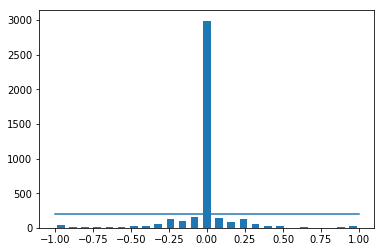

In [247]:
# plot a histogram for every set of images and steering angle to check distribution
num_bins = 25
samples_per_bin = 200
#returns 2 values - value of histogram and interval of data
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
#plot bar graph, we first specify the range of steering angle values, second value = hist and width of bar
plt.bar(center, hist, width=0.05)
# we now visualize
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data:  4053
removed:  2790
remaining:  1263


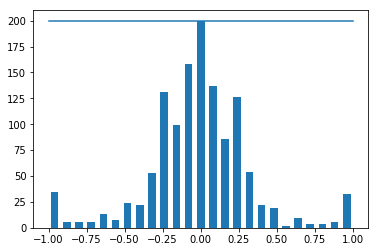

In [248]:
print('total data: ', len(data))
# on this list, we specify the sample we want to remove
remove_list = []
# now we start by looping through every single bin
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)
print('removed: ', len(remove_list))
#the values in remove_list
data.drop(data.index[remove_list], inplace=True)
print('remaining: ',len(data))

hist, _ = np.histogram(data['steering'], (num_bins))

plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [249]:
print(data.iloc[1])
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        # from row of data, we want to access the center, left and right images which are indices 0,1 and 2
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        # we only using centre images, which will append into image_path array, we are also appending into it
        # the main path. we'll be using .strip method which will eliminate any spaces 
        # that may be present in the string
        image_path.append(os.path.join(datadir, center.strip()))
        # now is where we append all the steering angles where steering is going to which is the 4th column
        # of the data
        steering.append(float(indexed_data[3]))
    # converts these lists into arrays
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    # we now return our images and steerings array
    return image_paths, steerings

# now we have 2 arrays, 1 array for the images and another array containing each array corresponding label
image_paths, steerings = load_img_steering(datadir + '/IMG', data)



center      center_2018_07_16_17_11_44_485.jpg
left        left_2018_07_16_17_11_44_485.jpg  
right       right_2018_07_16_17_11_44_485.jpg 
steering   -0.25                              
throttle    0.863326                          
reverse     0                                 
speed       2.17305                           
Name: 13, dtype: object


In [250]:
# we now need to split these arrays into random training and validation datasets
# hence we will use sklearn to train test split using the train_test_split method
# test size by defaut is 0.2

X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
# we print out the 
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))
# we make sure that both data sets have uniform distribution of steering angles

Training Samples: 1010
Valid Samples: 253


Text(0.5,1,'Validation set')

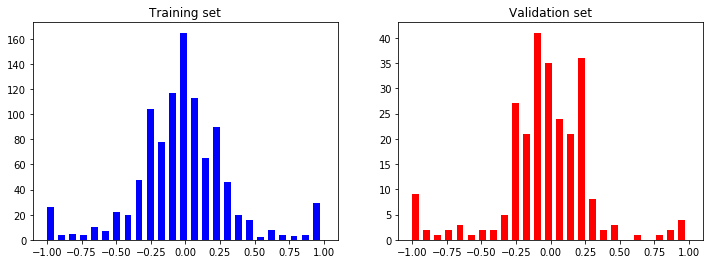

In [251]:
# we make sure that both data sets have uniform distribution of steering angles
# We now will have 2 histograms
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_bins, width = 0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width = 0.05, color='red')
axes[1].set_title('Validation set')

In [252]:
# Now we are going to preprocess our data and prepare it to be used inside our neural model. 
# we start off by building a function and take in a parameter image which is the image that gets processed
def img_preprocess(img):
    # datasets consists of image path, so the object we import is going to be an image path
    # so now we read the image path and store the actuale image that it contains
    img = mpimg.imread(img)
    # our image is essentially a 3 dimensional array which consist a hight, width and channel index
    img = img[60:135, :, :]
    # convert color from rgb to YUV - Y represents luminoscity while UV add colors to image
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    # apply gaussian blur to help reduce noise within the image as first argument, 
    #second argument which is size of gaussian kernel and deviation is 0
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200,66))
    # fimiliarise normalization
    img = img/255
    return img

Text(0.5,1,'Preprocessed Image')

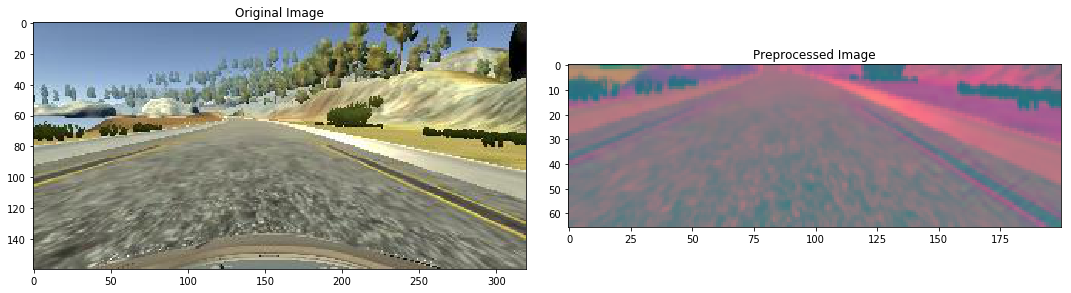

In [253]:
# we now visualize our images alongside our preprocessed images
# we start off by selecting a random image from our training data to visualise which in this case the 100th index of our array
image = image_paths[100]
# in order to compare our original image with our pre-processed image, we ned to define 2 images independently
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axs=plt.subplots(1,2, figsize = (15,10))
# we make sure our images are properly formatted and axes of our object do not overlap
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [254]:
# we now run pur set through out function
# map func because iterate array 
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

(1010, 66, 200, 3)


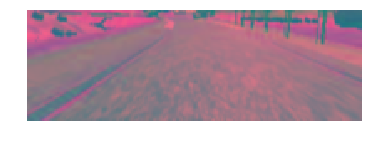

In [255]:
# so now plot some of our training data to verify that we preprocess this successfully
plt.imshow(X_train[random.randint(0,len(X_train)-1)])
plt.axis('off')
print(X_train.shape)
# the output then show 
# 1010 - 1010 images
# 66 - height
# 200 - width
# 3 - 3 channels

In [256]:
def nvidia_model():
    model = Sequential()
    # Higher subsampling means higher number of pixels being checked at any point of time so in this case
    # as our kernel is translated vertically or horizontally, it will movve 2 pixels
    # input shape is shape of our input images when recalled
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(66,200,3), activation='elu'))
    # we introduce our sencond convoultional 2d layer have 36 filters with kernel size of 5 x 5
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
    model.add(Convolution2D(64, 3, 3, activation='elu'))
    
    model.add(Convolution2D(64, 3, 3, activation='elu'))
    # drop out layer to prevent overfitting
    #within each update, these layers turn 50 percent of inputs they receive into 0
    model.add(Dropout(0.5))
    
    # we now add out flatten layer
    model.add(Flatten())
    # first layer will have 100 nodes and second will have 50 nodes and third dense layer will have 10 nodes. 
    # all of them will have the same relu activation
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(50, activation='elu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(10, activation='elu'))
    model.add(Dropout(0.5))
    # we then create a single dense layer with a single outout node that will output the predicted steering angle for our car
    model.add(Dense(1))
    
    # we compile our architecture to  compile our model before sending it off to being trained and since this is a 
    # regression type example, the error metric we will use is the mean squared error
    optimizer = Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    
    # we finally finish our nvidia model function by simply returning our model object
    return model

In [257]:
# define out model by calling nvidia
model = nvidia_model()
# print indepth summary of our model
print(model.summary())

C:\Users\Hakeem\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  
C:\Users\Hakeem\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  
C:\Users\Hakeem\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  if __name__ == '__main__':
C:\Users\Hakeem\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Hakeem\AppData\Local\Continuum\anaconda3\lib\site-packages\ipy

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_15 (Dropout)         (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1152)              0         
__________

In [258]:
#we define our training parameters so that we can train our first nvidia model and evaluate its performance
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose =1, shuffle=1)

Train on 1010 samples, validate on 253 samples
Epoch 1/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.8857 - val_loss: 0.1252
Epoch 2/30
1010/1010 [==============================] - 5s 5ms/step - loss: 0.2137 - val_loss: 0.1022
Epoch 3/30
1010/1010 [==============================] - 5s 5ms/step - loss: 0.1462 - val_loss: 0.0997
Epoch 4/30
1010/1010 [==============================] - 5s 5ms/step - loss: 0.1413 - val_loss: 0.0936
Epoch 5/30
1010/1010 [==============================] - 5s 5ms/step - loss: 0.1210 - val_loss: 0.0876
Epoch 6/30
1010/1010 [==============================] - 5s 5ms/step - loss: 0.1231 - val_loss: 0.0846
Epoch 7/30
1010/1010 [==============================] - 5s 5ms/step - loss: 0.1125 - val_loss: 0.0773
Epoch 8/30
1010/1010 [==============================] - 5s 5ms/step - loss: 0.1095 - val_loss: 0.0768
Epoch 9/30
1010/1010 [==============================] - 5s 5ms/step - loss: 0.0972 - val_loss: 0.0724
Epoch 10/30
1010/1010 [============

Text(0.5,0,'Epoch')

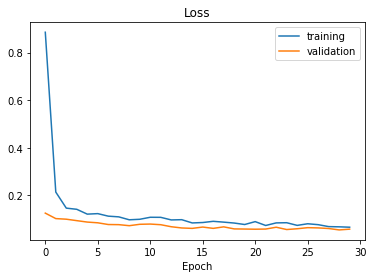

In [259]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [227]:
# we evaluat our model by putting it to the test 
# first of, we use the model save statement to save our model and we will call our model, 'model.h5'
model.save('model.h5')

In [228]:
# this import is to allow us to download our model.h5 file and the command is simply  below
from google.colab import files
files.download('model.h5')

ModuleNotFoundError: No module named 'google.colab'